<a href="https://www.kaggle.com/code/khadidjabrakta/resnet-pnemonia-pytorch?scriptVersionId=192889596" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T,datasets,models
import tqdm
import numpy as np
import pandas as pd

In [3]:
def data_transform(phase = None):
    if phase == Train:
        transform = T.Compose([
           T.Resize(size = (224 , 224)),
           T.RandomRotation(degrees = (-20 ,+20)),
           T.TrivialAugmentWide(num_magnitude_bins=31),
           T.ToTensor(),
           T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    elif phase == Test or phase == Val :
        transform = T.Compose([
           T.Resize(size = (224 , 224)),
           T.ToTensor(),
           T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    return transform    

In [4]:
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/"
Train = 'train'
Val = 'val'
Test = 'test'

In [5]:
import os
train_dataset = datasets.ImageFolder(os.path.join(data_dir,Train),transform = data_transform(Train))
test_dataset = datasets.ImageFolder(os.path.join(data_dir,Test),transform = data_transform(Test))
val_dataset = datasets.ImageFolder(os.path.join(data_dir,Val),transform = data_transform(Val))

In [6]:
train_dataset.classes

['NORMAL', 'PNEUMONIA']

In [7]:
train_data = DataLoader(train_dataset,batch_size = 64,shuffle = True)
valid_data = DataLoader(val_dataset,batch_size = 64,shuffle = True)
test_data = DataLoader(test_dataset,batch_size = 64,shuffle = True)

In [8]:
images, labels = next(iter(train_data))
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


Number of images in train directory:
Number of images in NORMAL folder: 1341
Number of images in PNEUMONIA folder: 3875

Number of images in val directory:
Number of images in NORMAL folder: 8
Number of images in PNEUMONIA folder: 8

Number of images in test directory:
Number of images in NORMAL folder: 234
Number of images in PNEUMONIA folder: 390

Random sample of images from train directory:


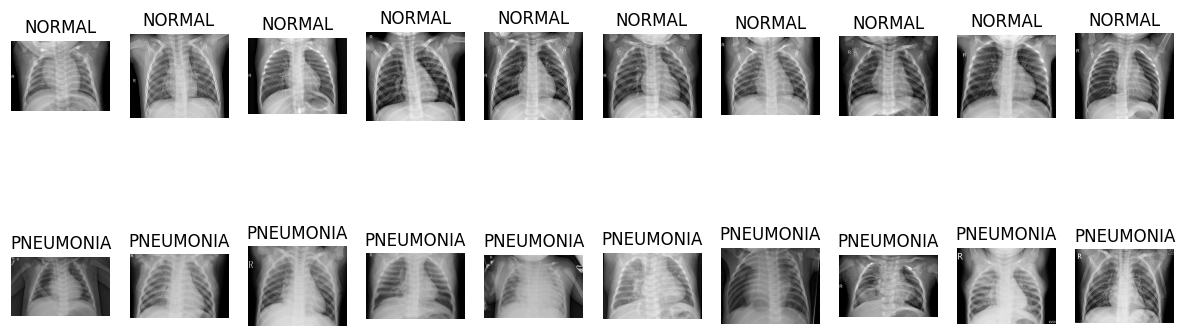


Random sample of images from val directory:


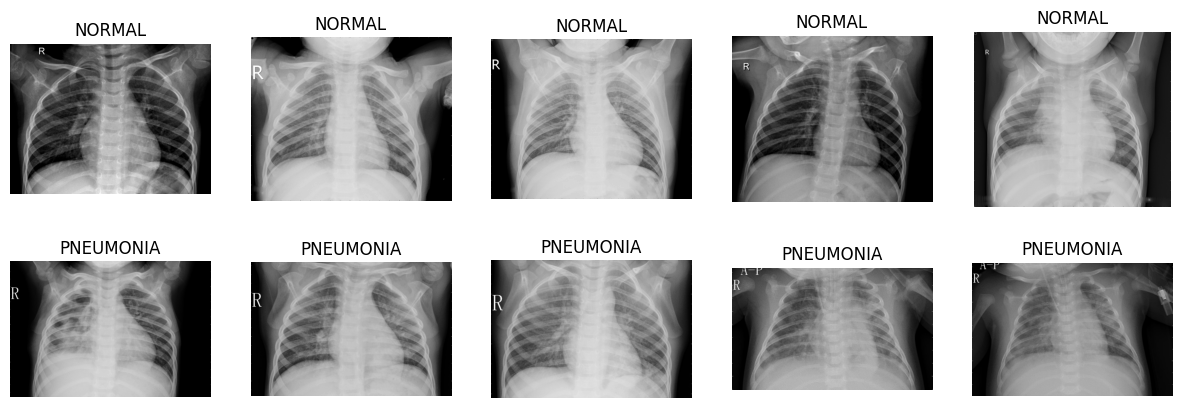


Random sample of images from test directory:


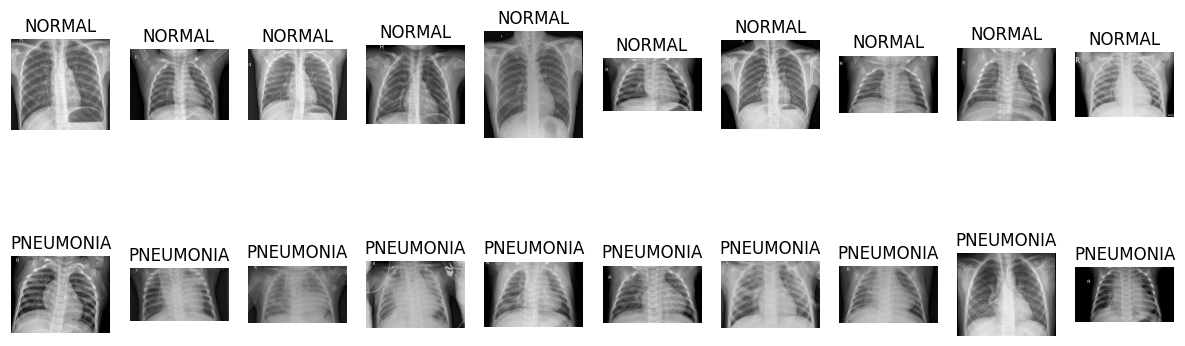

In [9]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Define directories
# Adjusted directory paths
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'


# Define classes
classes = ['NORMAL', 'PNEUMONIA']
# Function to print number of images in each folder
def print_num_images(directory):
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        num_images = len(os.listdir(class_dir))
        print(f"Number of images in {cls} folder: {num_images}")

# Function to plot random sample of images
def plot_random_images(directory, num_samples=10):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 5))

    for i, cls in enumerate(classes):
        class_dir = os.path.join(directory, cls)
        image_files = random.sample(os.listdir(class_dir), num_samples)
        for j, image_file in enumerate(image_files):
            img = mpimg.imread(os.path.join(class_dir, image_file))
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(cls)

    plt.show()

# Print number of images in each folder
print("Number of images in train directory:")
print_num_images(train_dir)
print("\nNumber of images in val directory:")
print_num_images(val_dir)
print("\nNumber of images in test directory:")
print_num_images(test_dir)

# Plot random sample of images
print("\nRandom sample of images from train directory:")
plot_random_images(train_dir)
print("\nRandom sample of images from val directory:")
plot_random_images(val_dir,num_samples=5)
print("\nRandom sample of images from test directory:")
plot_random_images(test_dir)

In [10]:
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print("Number of available GPUs:", num_gpus)

    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print("GPU", i, ":", gpu_name)
else:
    print("CUDA is not available. Using CPU.")

Number of available GPUs: 1
GPU 0 : Tesla P100-PCIE-16GB


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
import torchvision.models as models

model = models.resnet18(pretrained=False) 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
model.load_state_dict(torch.load('/kaggle/input/resnet18/pytorch/default/1/resnet18-f37072fd.pth'))

<All keys matched successfully>

In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
num_ftrs = model.fc.in_features
num_ftrs

512

In [17]:
model.fc = nn.Linear(num_ftrs, 2)

In [18]:
model = model.to(device)

In [19]:
device

device(type='cuda')

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_data:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{10}, Loss: {running_loss/len(train_data)}")


Epoch 1/10, Loss: 0.2333055507482552
Epoch 2/10, Loss: 0.14314471353299735
Epoch 3/10, Loss: 0.11884545044201177
Epoch 4/10, Loss: 0.09518712150250994
Epoch 5/10, Loss: 0.09621651470661163
Epoch 6/10, Loss: 0.09064316592837979
Epoch 7/10, Loss: 0.09095509875020603
Epoch 8/10, Loss: 0.0876091951050046
Epoch 9/10, Loss: 0.07533507477264942
Epoch 10/10, Loss: 0.08550158490585845


In [21]:
import torchmetrics
from torchmetrics.classification import Accuracy
import torch

# Initialize accuracy metric
accuracy_metric = Accuracy(task="binary").to(device)

model.eval()
accuracy_metric.reset()
total = 0

with torch.no_grad():
    for inputs, labels in test_data:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Get model outputs
        outputs = model(inputs)
        
        # Convert logits to probabilities and then to class predictions
        if outputs.shape[1] == 2:  # Assuming output shape is [batch_size, num_classes]
            outputs = torch.argmax(outputs, dim=1)  # Get the predicted class indices
        else:
            # If model outputs probabilities, convert probabilities to binary labels
            outputs = (outputs > 0.5).long()  # Convert probabilities to binary labels
        
        # Update accuracy metric
        accuracy_metric.update(outputs, labels)
    
    final_accuracy = accuracy_metric.compute()
    print(f'Accuracy on the test set: {final_accuracy:.2%}')

Accuracy on the test set: 83.81%


In [22]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.show()


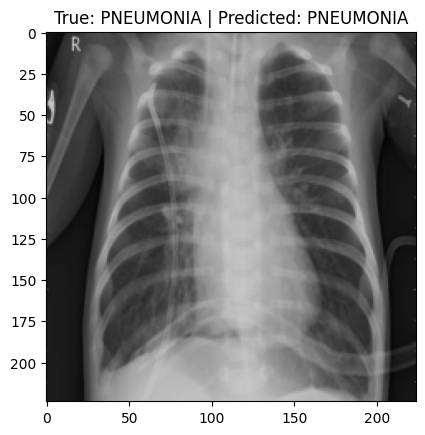

In [23]:
model.eval()

# Get class names from the test dataset
class_names = test_dataset.classes

# Predict and plot
with torch.no_grad():
    for inputs, labels in test_data:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs
        labels = labels

        # Predict the label
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        imshow(inputs.cpu().data[0], title=f"True: {class_names[labels[0]]} | Predicted: {class_names[preds[0]]}")
        break


In [24]:
torch.save(model.state_dict(), 'pneumonia_detection_model.pth')